# Practical FFT Applications

This notebook demonstrates real-world applications of FFT including spectral analysis, noise filtering, and windowing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)

## 1. Spectral Analysis of Combined Waveforms

Analyzing a complex signal to identify its frequency components.

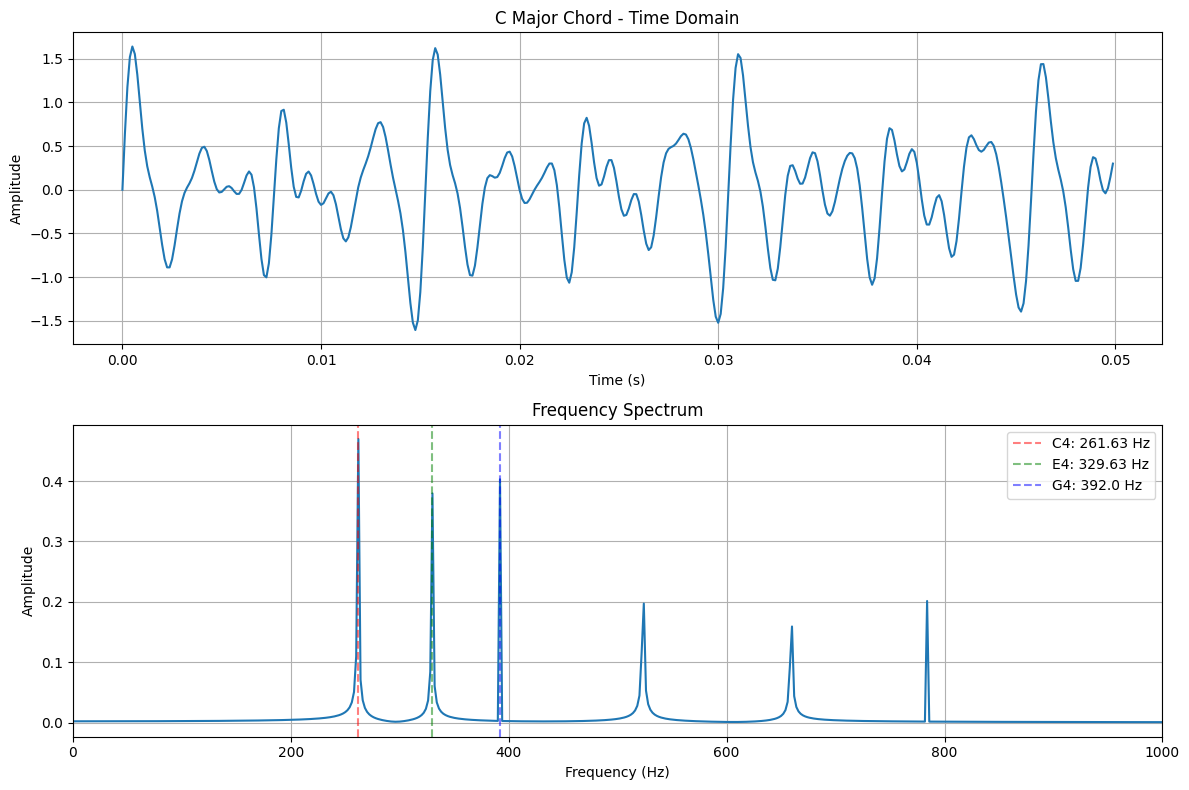

Detected frequency components:
  260.0 Hz (amplitude: 0.110)
  262.0 Hz (amplitude: 0.470)
  330.0 Hz (amplitude: 0.379)
  392.0 Hz (amplitude: 0.403)
  522.0 Hz (amplitude: 0.116)
  524.0 Hz (amplitude: 0.197)
  660.0 Hz (amplitude: 0.159)
  784.0 Hz (amplitude: 0.201)


In [2]:
# Create a complex signal simulating a musical chord
sample_rate = 8000  # Hz
duration = 0.5  # seconds
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Frequencies approximating a C major chord (C4, E4, G4)
f_c4 = 261.63  # C4
f_e4 = 329.63  # E4
f_g4 = 392.00  # G4

# Generate chord with harmonics
signal = (0.5 * np.sin(2 * np.pi * f_c4 * t) + 
          0.25 * np.sin(2 * np.pi * 2 * f_c4 * t) +  # 2nd harmonic
          0.4 * np.sin(2 * np.pi * f_e4 * t) + 
          0.2 * np.sin(2 * np.pi * 2 * f_e4 * t) +   # 2nd harmonic
          0.4 * np.sin(2 * np.pi * f_g4 * t) + 
          0.2 * np.sin(2 * np.pi * 2 * f_g4 * t))    # 2nd harmonic

# Compute FFT
n_samples = len(signal)
fft_result = np.fft.rfft(signal)
frequencies = np.fft.rfftfreq(n_samples, d=1/sample_rate)
magnitude = np.abs(fft_result) / n_samples * 2

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Time domain (show only first few cycles)
axes[0].plot(t[:400], signal[:400])
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('C Major Chord - Time Domain')
axes[0].grid(True)

# Frequency domain
axes[1].plot(frequencies, magnitude)
axes[1].axvline(x=f_c4, color='r', linestyle='--', alpha=0.5, label=f'C4: {f_c4} Hz')
axes[1].axvline(x=f_e4, color='g', linestyle='--', alpha=0.5, label=f'E4: {f_e4} Hz')
axes[1].axvline(x=f_g4, color='b', linestyle='--', alpha=0.5, label=f'G4: {f_g4} Hz')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Frequency Spectrum')
axes[1].set_xlim(0, 1000)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Find peaks
threshold = 0.1
peaks = np.where(magnitude > threshold)[0]
print("Detected frequency components:")
for idx in peaks:
    print(f"  {frequencies[idx]:.1f} Hz (amplitude: {magnitude[idx]:.3f})")

## 2. Noise Filtering in the Frequency Domain

One of the most practical applications of FFT: removing noise by filtering in the frequency domain.

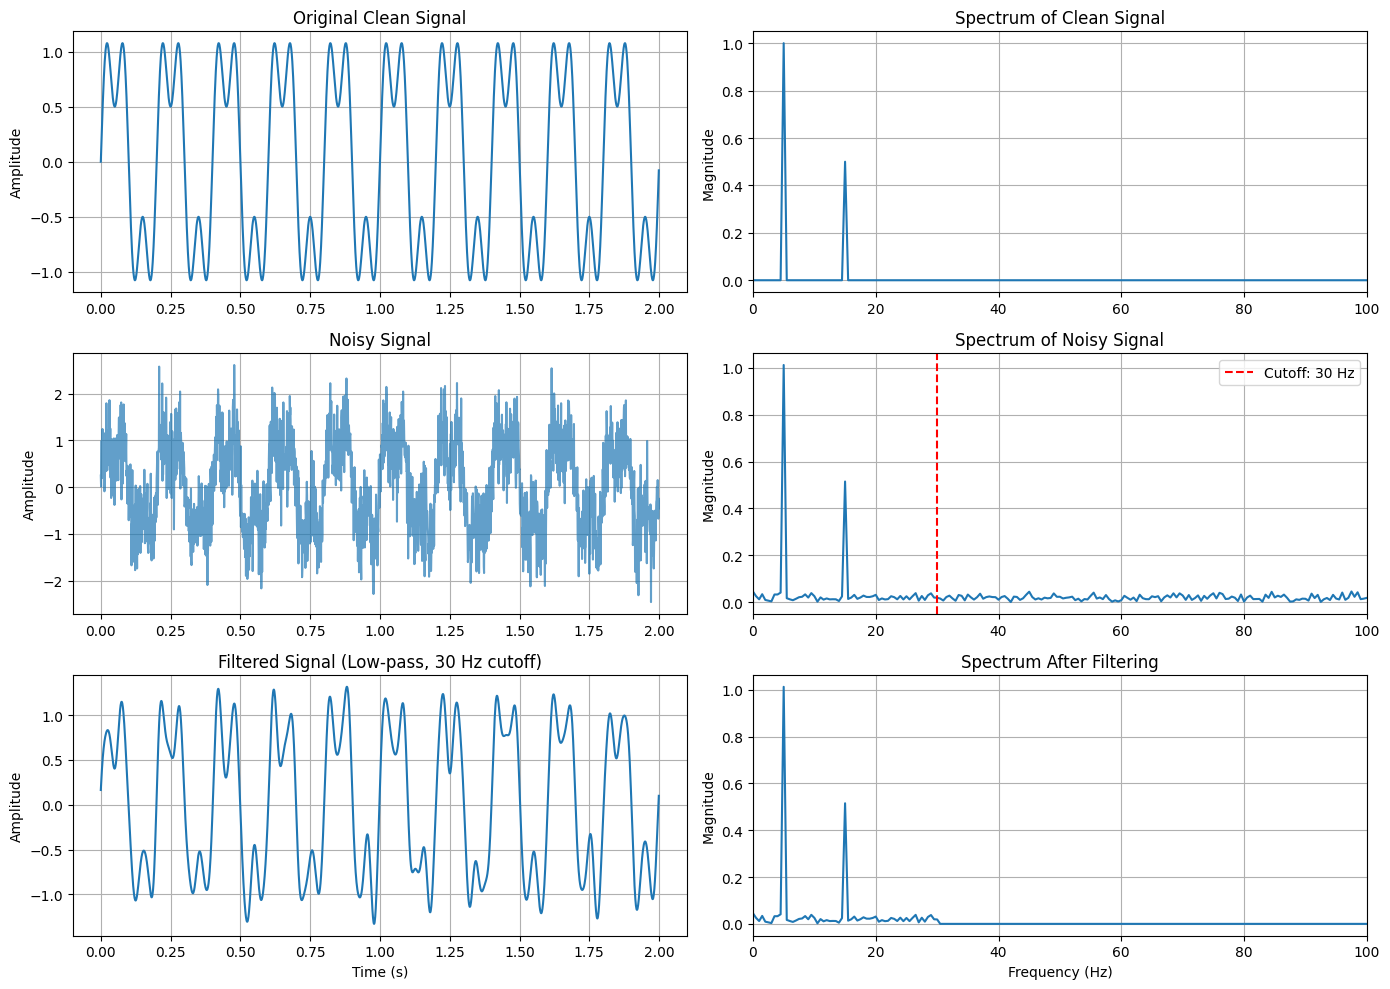

In [3]:
# Create a clean signal
sample_rate = 1000
duration = 2.0
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Target signal: 5 Hz + 15 Hz
clean_signal = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 15 * t)

# Add high-frequency noise
np.random.seed(42)
noise = 0.5 * np.random.randn(len(t))
noisy_signal = clean_signal + noise

# FFT of noisy signal
n_samples = len(noisy_signal)
fft_noisy = np.fft.rfft(noisy_signal)
frequencies = np.fft.rfftfreq(n_samples, d=1/sample_rate)

# Design a low-pass filter: keep frequencies below 30 Hz
cutoff_freq = 30  # Hz
filter_mask = frequencies <= cutoff_freq

# Apply filter
fft_filtered = fft_noisy.copy()
fft_filtered[~filter_mask] = 0

# Inverse FFT to get filtered signal
filtered_signal = np.fft.irfft(fft_filtered)

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Time domain plots
axes[0, 0].plot(t, clean_signal)
axes[0, 0].set_title('Original Clean Signal')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True)

axes[1, 0].plot(t, noisy_signal, alpha=0.7)
axes[1, 0].set_title('Noisy Signal')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True)

axes[2, 0].plot(t, filtered_signal)
axes[2, 0].set_title('Filtered Signal (Low-pass, 30 Hz cutoff)')
axes[2, 0].set_xlabel('Time (s)')
axes[2, 0].set_ylabel('Amplitude')
axes[2, 0].grid(True)

# Frequency domain plots
axes[0, 1].plot(frequencies, np.abs(np.fft.rfft(clean_signal)) / n_samples * 2)
axes[0, 1].set_title('Spectrum of Clean Signal')
axes[0, 1].set_ylabel('Magnitude')
axes[0, 1].set_xlim(0, 100)
axes[0, 1].grid(True)

axes[1, 1].plot(frequencies, np.abs(fft_noisy) / n_samples * 2)
axes[1, 1].axvline(x=cutoff_freq, color='r', linestyle='--', label=f'Cutoff: {cutoff_freq} Hz')
axes[1, 1].set_title('Spectrum of Noisy Signal')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].set_xlim(0, 100)
axes[1, 1].legend()
axes[1, 1].grid(True)

axes[2, 1].plot(frequencies, np.abs(fft_filtered) / n_samples * 2)
axes[2, 1].set_title('Spectrum After Filtering')
axes[2, 1].set_xlabel('Frequency (Hz)')
axes[2, 1].set_ylabel('Magnitude')
axes[2, 1].set_xlim(0, 100)
axes[2, 1].grid(True)

plt.tight_layout()
plt.show()

## 3. Band-pass Filtering

Extract only frequencies within a specific range.

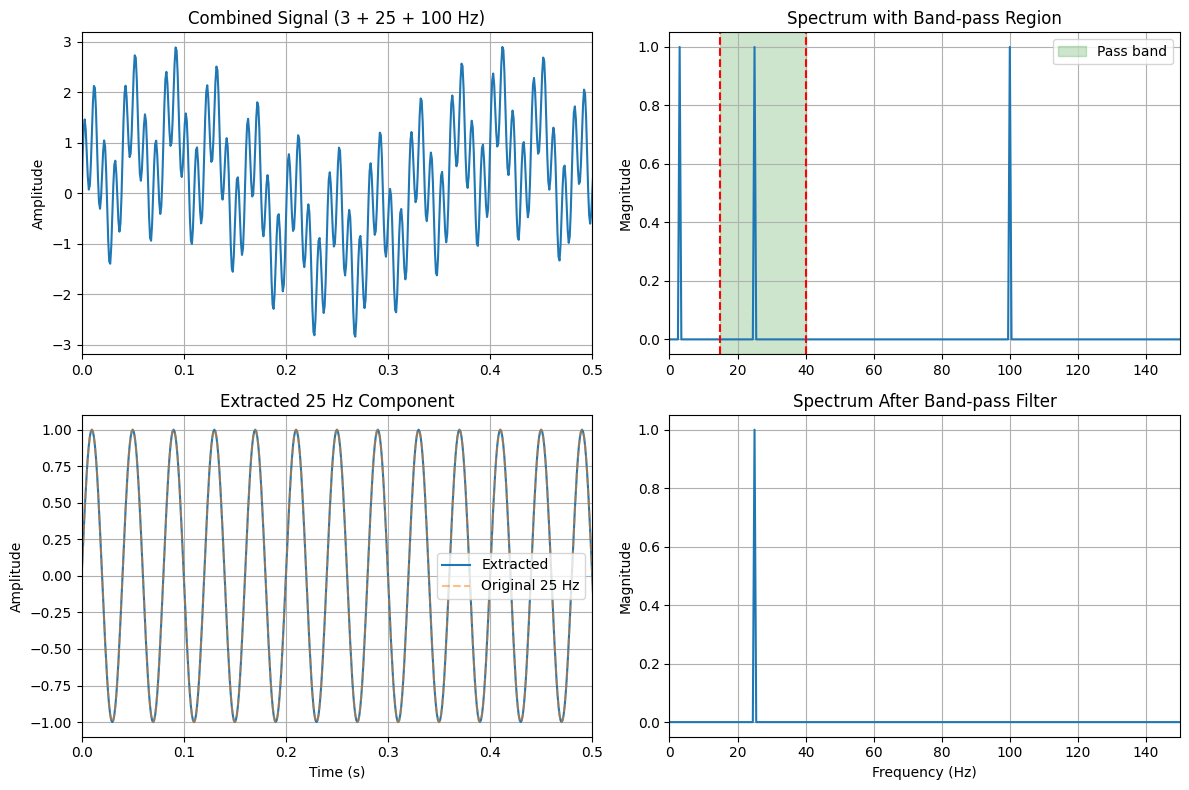

In [4]:
# Signal with low, mid, and high frequency components
sample_rate = 1000
duration = 2.0
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

low_freq = np.sin(2 * np.pi * 3 * t)      # 3 Hz
mid_freq = np.sin(2 * np.pi * 25 * t)     # 25 Hz (target)
high_freq = np.sin(2 * np.pi * 100 * t)   # 100 Hz

combined = low_freq + mid_freq + high_freq

# Band-pass filter: keep 15-40 Hz
n_samples = len(combined)
fft_result = np.fft.rfft(combined)
frequencies = np.fft.rfftfreq(n_samples, d=1/sample_rate)

low_cutoff = 15
high_cutoff = 40
band_mask = (frequencies >= low_cutoff) & (frequencies <= high_cutoff)

fft_bandpass = fft_result.copy()
fft_bandpass[~band_mask] = 0

extracted = np.fft.irfft(fft_bandpass)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(t, combined)
axes[0, 0].set_title('Combined Signal (3 + 25 + 100 Hz)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_xlim(0, 0.5)
axes[0, 0].grid(True)

axes[0, 1].plot(frequencies, np.abs(fft_result) / n_samples * 2)
axes[0, 1].axvline(x=low_cutoff, color='r', linestyle='--')
axes[0, 1].axvline(x=high_cutoff, color='r', linestyle='--')
axes[0, 1].axvspan(low_cutoff, high_cutoff, alpha=0.2, color='green', label='Pass band')
axes[0, 1].set_title('Spectrum with Band-pass Region')
axes[0, 1].set_ylabel('Magnitude')
axes[0, 1].set_xlim(0, 150)
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(t, extracted, label='Extracted')
axes[1, 0].plot(t, mid_freq, '--', alpha=0.5, label='Original 25 Hz')
axes[1, 0].set_title('Extracted 25 Hz Component')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_xlim(0, 0.5)
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(frequencies, np.abs(fft_bandpass) / n_samples * 2)
axes[1, 1].set_title('Spectrum After Band-pass Filter')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].set_xlim(0, 150)
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 4. Windowing and Spectral Leakage

When a signal doesn't contain an exact number of cycles, FFT produces "spectral leakage". Window functions reduce this effect.

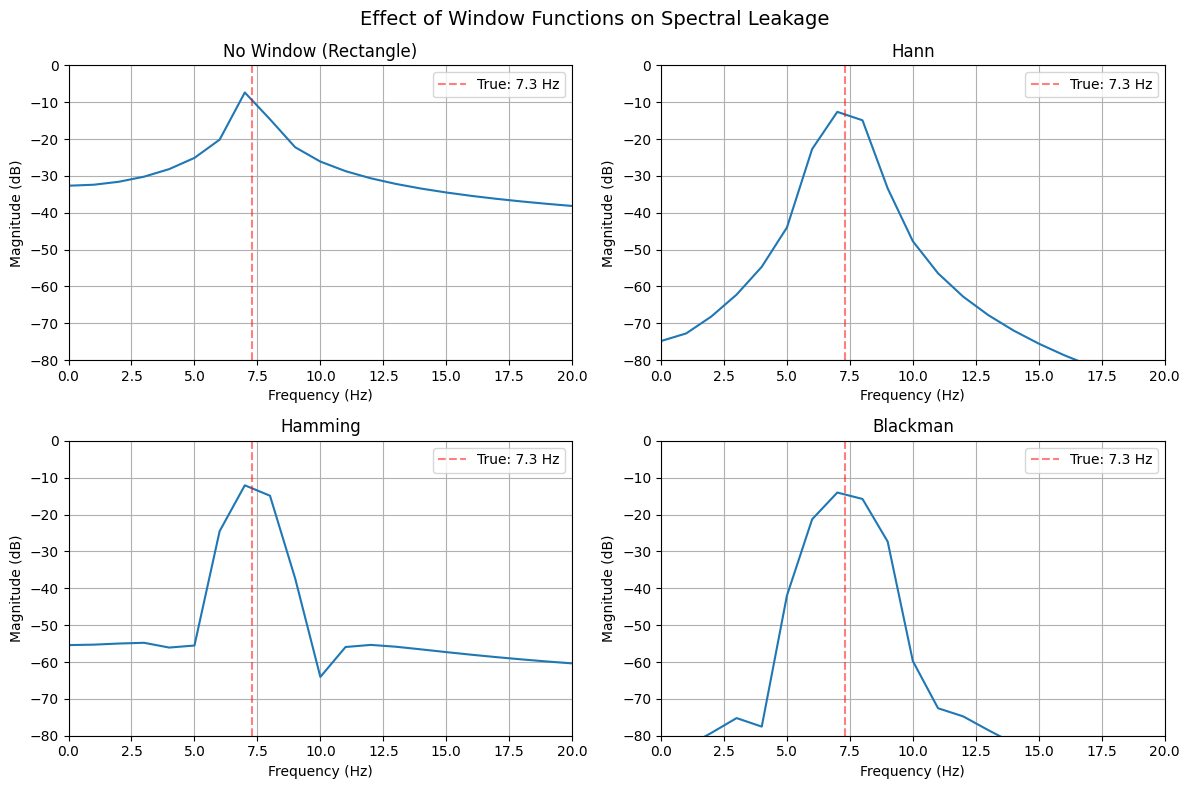

In [5]:
# Signal with non-integer number of cycles
sample_rate = 100
duration = 1.0
frequency = 7.3  # Not a nice integer!

t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
signal = np.sin(2 * np.pi * frequency * t)

n_samples = len(signal)
frequencies = np.fft.rfftfreq(n_samples, d=1/sample_rate)

# Without windowing
fft_no_window = np.fft.rfft(signal)

# With different window functions
windows = {
    'No Window (Rectangle)': np.ones(n_samples),
    'Hann': np.hanning(n_samples),
    'Hamming': np.hamming(n_samples),
    'Blackman': np.blackman(n_samples)
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, (name, window) in zip(axes.flat, windows.items()):
    windowed_signal = signal * window
    fft_windowed = np.fft.rfft(windowed_signal)
    magnitude_db = 20 * np.log10(np.abs(fft_windowed) / n_samples + 1e-10)
    
    ax.plot(frequencies, magnitude_db)
    ax.axvline(x=frequency, color='r', linestyle='--', alpha=0.5, label=f'True: {frequency} Hz')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude (dB)')
    ax.set_title(name)
    ax.set_xlim(0, 20)
    ax.set_ylim(-80, 0)
    ax.legend()
    ax.grid(True)

plt.suptitle('Effect of Window Functions on Spectral Leakage', fontsize=14)
plt.tight_layout()
plt.show()

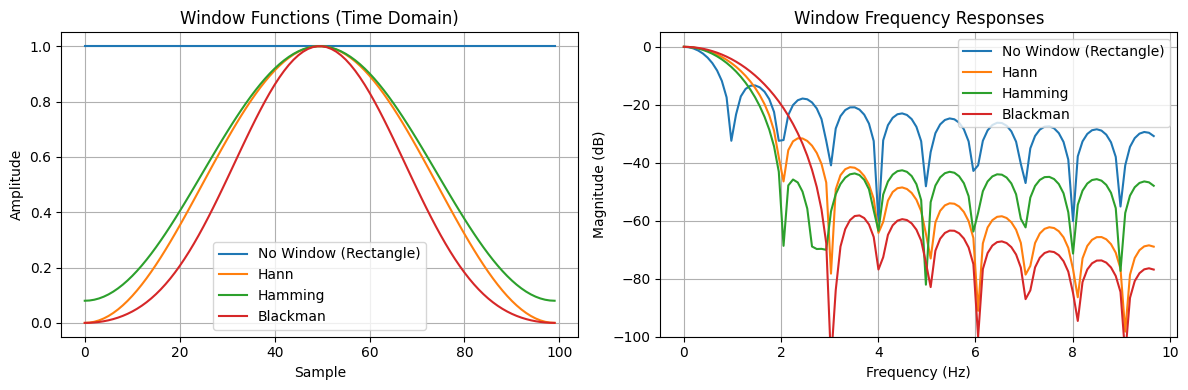

In [6]:
# Visualize the window functions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Time domain
for name, window in windows.items():
    axes[0].plot(window, label=name)
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Window Functions (Time Domain)')
axes[0].legend()
axes[0].grid(True)

# Frequency response of windows
for name, window in windows.items():
    # Zero-pad for better frequency resolution
    padded = np.zeros(1024)
    padded[:len(window)] = window
    fft_window = np.fft.rfft(padded)
    freq_response = 20 * np.log10(np.abs(fft_window) / np.max(np.abs(fft_window)) + 1e-10)
    freqs = np.fft.rfftfreq(1024, d=1/sample_rate)
    axes[1].plot(freqs[:100], freq_response[:100], label=name)

axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (dB)')
axes[1].set_title('Window Frequency Responses')
axes[1].set_ylim(-100, 5)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 5. Removing a Specific Frequency (Notch Filter)

Remove a known interference frequency (e.g., 60 Hz power line noise).

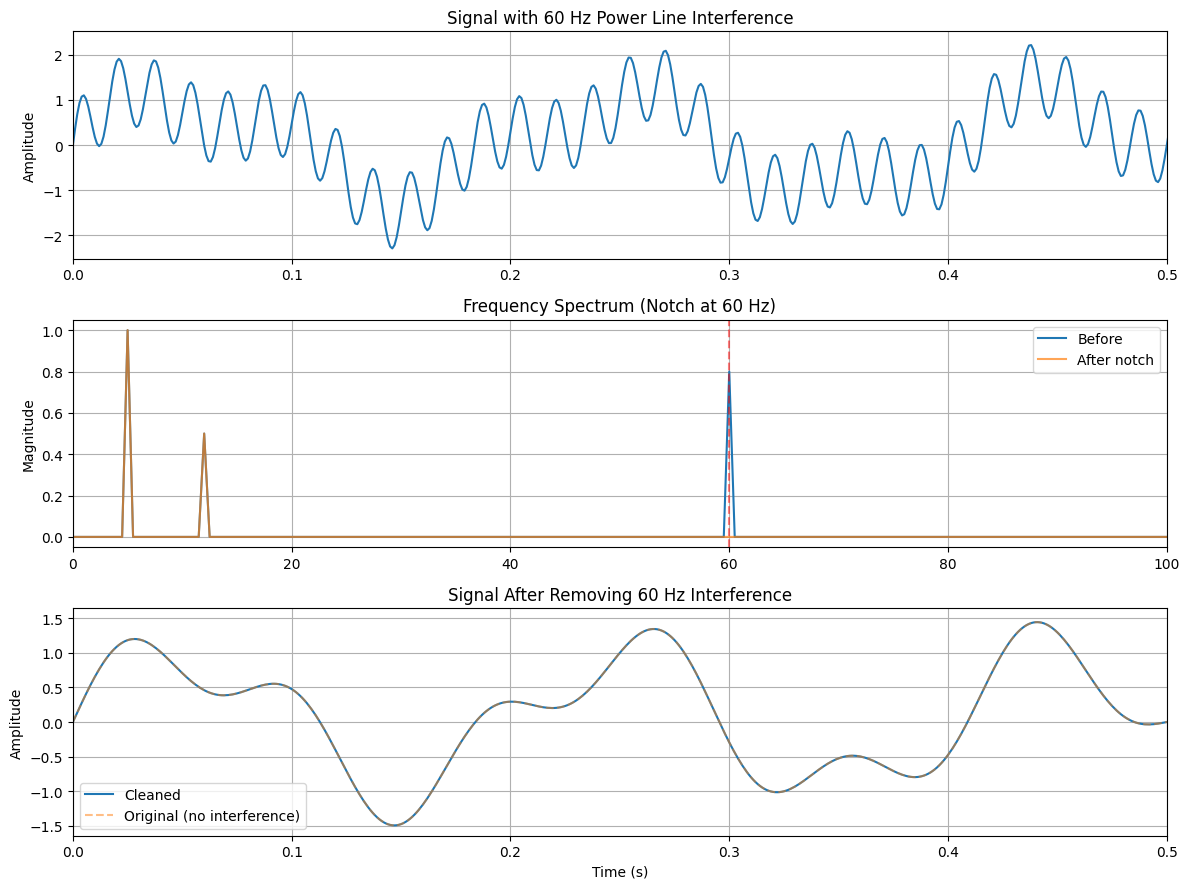

In [7]:
# Simulate a signal with power line interference
sample_rate = 1000
duration = 2.0
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Desired signal: low frequency content
desired = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 12 * t)

# Power line interference at 60 Hz
interference = 0.8 * np.sin(2 * np.pi * 60 * t)

contaminated = desired + interference

# Notch filter: remove frequencies around 60 Hz
n_samples = len(contaminated)
fft_result = np.fft.rfft(contaminated)
frequencies = np.fft.rfftfreq(n_samples, d=1/sample_rate)

# Create notch at 60 Hz (with small bandwidth)
notch_freq = 60
notch_width = 2  # Hz
notch_mask = (frequencies >= notch_freq - notch_width) & (frequencies <= notch_freq + notch_width)

fft_notched = fft_result.copy()
fft_notched[notch_mask] = 0

cleaned = np.fft.irfft(fft_notched)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

axes[0].plot(t, contaminated)
axes[0].set_title('Signal with 60 Hz Power Line Interference')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim(0, 0.5)
axes[0].grid(True)

axes[1].plot(frequencies, np.abs(fft_result) / n_samples * 2, label='Before')
axes[1].plot(frequencies, np.abs(fft_notched) / n_samples * 2, label='After notch', alpha=0.7)
axes[1].axvline(x=notch_freq, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Frequency Spectrum (Notch at 60 Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_xlim(0, 100)
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t, cleaned, label='Cleaned')
axes[2].plot(t, desired, '--', alpha=0.5, label='Original (no interference)')
axes[2].set_title('Signal After Removing 60 Hz Interference')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlim(0, 0.5)
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 6. Interactive Parameter Exploration

If ipywidgets is available, explore FFT parameters interactively.

In [8]:
try:
    from ipywidgets import interact, FloatSlider, IntSlider
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("ipywidgets not available. Install with: pip install ipywidgets")
    print("Showing static example instead.")

In [9]:
def explore_fft(frequency=10.0, amplitude=1.0, noise_level=0.0, window='none'):
    """Interactive FFT exploration."""
    sample_rate = 1000
    duration = 1.0
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    n_samples = len(t)
    
    # Generate signal
    signal = amplitude * np.sin(2 * np.pi * frequency * t)
    
    # Add noise
    if noise_level > 0:
        signal += noise_level * np.random.randn(n_samples)
    
    # Apply window
    if window == 'hann':
        signal = signal * np.hanning(n_samples)
    elif window == 'hamming':
        signal = signal * np.hamming(n_samples)
    elif window == 'blackman':
        signal = signal * np.blackman(n_samples)
    
    # FFT
    fft_result = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(n_samples, d=1/sample_rate)
    magnitude = np.abs(fft_result) / n_samples * 2
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(t, signal)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f'Signal: {frequency:.1f} Hz')
    axes[0].grid(True)
    axes[0].set_ylim(-3, 3)
    
    axes[1].plot(frequencies, magnitude)
    axes[1].axvline(x=frequency, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Magnitude')
    axes[1].set_title('FFT Magnitude Spectrum')
    axes[1].set_xlim(0, 100)
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

if WIDGETS_AVAILABLE:
    interact(
        explore_fft,
        frequency=FloatSlider(min=1, max=50, step=0.5, value=10, description='Frequency (Hz)'),
        amplitude=FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0, description='Amplitude'),
        noise_level=FloatSlider(min=0, max=1.0, step=0.1, value=0, description='Noise Level'),
        window=['none', 'hann', 'hamming', 'blackman']
    )
else:
    # Static example
    explore_fft(frequency=15.0, amplitude=1.0, noise_level=0.2, window='hann')

interactive(children=(FloatSlider(value=10.0, description='Frequency (Hz)', max=50.0, min=1.0, step=0.5), Floa…

In [10]:
def explore_filtering(signal_freq=10, noise_freq=60, cutoff=30):
    """Interactive noise filtering exploration."""
    sample_rate = 1000
    duration = 1.0
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    n_samples = len(t)
    
    # Create signal with noise
    clean = np.sin(2 * np.pi * signal_freq * t)
    noise = 0.5 * np.sin(2 * np.pi * noise_freq * t)
    noisy = clean + noise
    
    # Filter
    fft_result = np.fft.rfft(noisy)
    frequencies = np.fft.rfftfreq(n_samples, d=1/sample_rate)
    
    fft_filtered = fft_result.copy()
    fft_filtered[frequencies > cutoff] = 0
    
    filtered = np.fft.irfft(fft_filtered)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    axes[0, 0].plot(t, noisy)
    axes[0, 0].set_title(f'Noisy Signal ({signal_freq} Hz + {noise_freq} Hz noise)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(frequencies, np.abs(fft_result) / n_samples * 2)
    axes[0, 1].axvline(x=cutoff, color='r', linestyle='--', label=f'Cutoff: {cutoff} Hz')
    axes[0, 1].set_title('Spectrum Before Filtering')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlim(0, 100)
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(t, filtered, label='Filtered')
    axes[1, 0].plot(t, clean, '--', alpha=0.5, label='Original clean')
    axes[1, 0].set_title('Filtered Signal')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(frequencies, np.abs(fft_filtered) / n_samples * 2)
    axes[1, 1].set_title('Spectrum After Filtering')
    axes[1, 1].set_xlabel('Frequency (Hz)')
    axes[1, 1].set_ylabel('Magnitude')
    axes[1, 1].set_xlim(0, 100)
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

if WIDGETS_AVAILABLE:
    interact(
        explore_filtering,
        signal_freq=IntSlider(min=5, max=30, value=10, description='Signal (Hz)'),
        noise_freq=IntSlider(min=40, max=100, value=60, description='Noise (Hz)'),
        cutoff=IntSlider(min=10, max=80, value=30, description='Cutoff (Hz)')
    )
else:
    explore_filtering(signal_freq=10, noise_freq=60, cutoff=30)

interactive(children=(IntSlider(value=10, description='Signal (Hz)', max=30, min=5), IntSlider(value=60, descr…

## Summary

In this notebook, we covered practical applications of FFT:

1. **Spectral Analysis** - Identifying frequency components in complex signals
2. **Low-pass Filtering** - Removing high-frequency noise
3. **Band-pass Filtering** - Extracting specific frequency ranges
4. **Windowing** - Reducing spectral leakage for non-periodic signals
5. **Notch Filtering** - Removing specific interference frequencies
6. **Interactive Exploration** - Understanding FFT parameters visually

These techniques form the foundation for signal processing applications in audio, communications, scientific instrumentation, and many other fields.